/var/folders/mk/w8s3nzl959jgkn1zkrxxf0yw0000gn/T/ipykernel_47640/2324560074.py:14: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff = pdr.DataReader(
/var/folders/mk/w8s3nzl959jgkn1zkrxxf0yw0000gn/T/ipykernel_47640/2324560074.py:14: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  ff = pdr.DataReader(


Factor,Final Value ($),CAGR (%),Volatility (%),Sharpe,Max Drawdown (%)
Size (SMB),798,-1.18,9.37,-0.08,-35.41


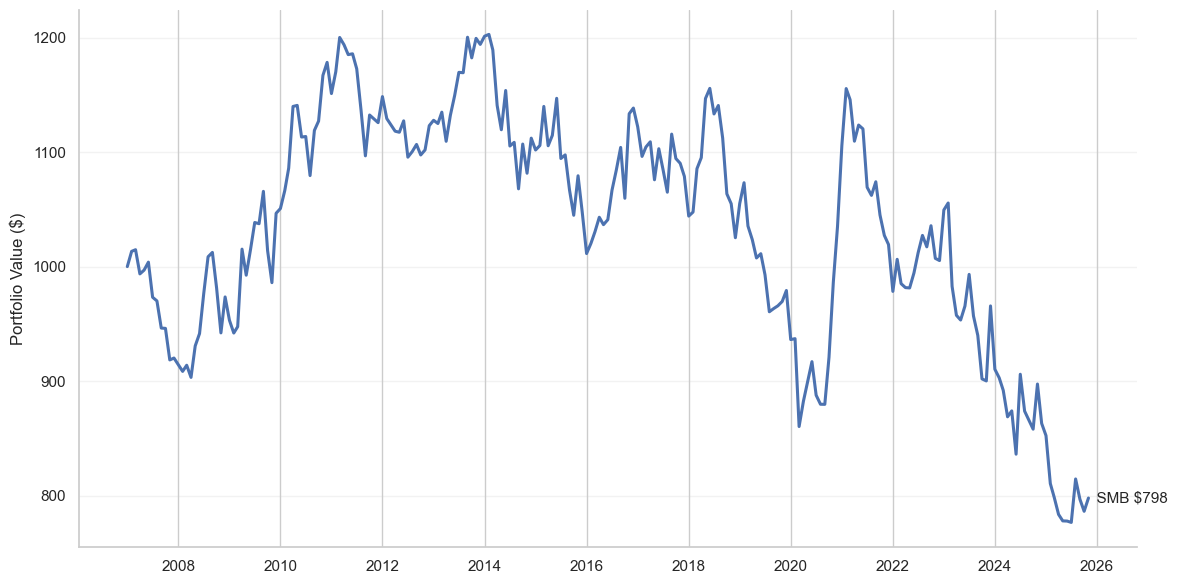

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from pandas_datareader import data as pdr

sns.set_theme(style="whitegrid")

START_DATE = "2007-01-01"
INITIAL_CAPITAL = 1000
ANNUALIZATION = 12

ff = pdr.DataReader(
    "F-F_Research_Data_5_Factors_2x3",
    "famafrench",
    start=START_DATE
)[0]

ff = ff / 100.0
ff.index = ff.index.to_timestamp()

smb = ff["SMB"].rename("SMB")

smb_pnl = (1 + smb).cumprod() * INITIAL_CAPITAL
final_value = smb_pnl.iloc[-1]

years = len(smb) / ANNUALIZATION
cagr = (final_value / INITIAL_CAPITAL) ** (1 / years) - 1
vol = smb.std() * np.sqrt(ANNUALIZATION)
sharpe = smb.mean() / smb.std() * np.sqrt(ANNUALIZATION)

drawdown = smb_pnl / smb_pnl.cummax() - 1
max_dd = drawdown.min()

performance = pd.DataFrame(
    {
        "Factor": ["Size (SMB)"],
        "Final Value ($)": [final_value],
        "CAGR (%)": [cagr * 100],
        "Volatility (%)": [vol * 100],
        "Sharpe": [sharpe],
        "Max Drawdown (%)": [max_dd * 100],
    }
)

display(
    performance.style
    .hide(axis="index")
    .format({
        "Final Value ($)": "{:,.0f}",
        "CAGR (%)": "{:.2f}",
        "Volatility (%)": "{:.2f}",
        "Sharpe": "{:.2f}",
        "Max Drawdown (%)": "{:.2f}",
    })
)

fig, ax = plt.subplots(figsize=(12, 6))

ax.plot(smb_pnl.index, smb_pnl.values, lw=2.2)
ax.text(
    smb_pnl.index[-1],
    final_value,
    f"  SMB ${final_value:,.0f}",
    fontsize=11,
    va="center"
)

ax.set_ylabel("Portfolio Value ($)")
ax.xaxis.set_major_locator(mdates.YearLocator(2))
ax.xaxis.set_major_formatter(mdates.DateFormatter("%Y"))
ax.spines["top"].set_visible(False)
ax.spines["right"].set_visible(False)
ax.grid(True, axis="y", alpha=0.25)

plt.tight_layout()
plt.show()


In [ ]:
# ------------------------------------------------------------
# Static regressions: Factor vs Market
# ------------------------------------------------------------

import statsmodels.api as sm

reg_results = []

market = factors["MKT"]

for factor in factors.columns:
    if factor == "MKT":
        continue

    y = factors[factor]
    X = sm.add_constant(market)

    model = sm.OLS(y, X).fit()

    reg_results.append({
        "Factor": factor,
        "Alpha": model.params["const"],
        "Beta": model.params["MKT"],
        "t(Alpha)": model.tvalues["const"],
        "t(Beta)": model.tvalues["MKT"],
        "R2": model.rsquared
    })

reg_table = pd.DataFrame(reg_results).set_index("Factor")
display(reg_table.round(3))


In [ ]:
import pandas as pd
import numpy as np
import yfinance as yf
from pandas_datareader import data as pdr

# -----------------------------
# Configuration
# -----------------------------

# ============================================================
# ASSET UNIVERSE — FULL ETF NAMES & ECONOMIC ROLE
# ============================================================

# SPY  — SPDR S&P 500 ETF Trust
#        US large-cap equities, broad market beta

# QQQ  — Invesco QQQ Trust
#        US large-cap growth equities, Nasdaq-100 (tech-heavy)

# IWM  — iShares Russell 2000 ETF
#        US small-cap equities, domestic growth & risk-on proxy

# IWD  — iShares Russell 1000 Value ETF
#        US large-cap value equities, cyclical / valuation factor

# TLT  — iShares 20+ Year Treasury Bond ETF
#        Long-duration US Treasuries, rates & risk-off hedge

# HYG  — iShares iBoxx $ High Yield Corporate Bond ETF
#        US high-yield credit, credit risk & economic cycle proxy

# GLD  — SPDR Gold Shares
#        Physical gold, inflation hedge & monetary stress asset

# GSG  — iShares S&P GSCI Commodity-Indexed Trust
#        Broad commodity exposure, inflation & real assets proxy

# VNQ  — Vanguard Real Estate ETF
#        US REITs, real estate & interest-rate-sensitive equities
# ============================================================

ASSETS = [
    "SPY", "QQQ", "IWM", "IWD",
    "TLT", "HYG", "GLD", "GSG", "VNQ"
]

START = "2021-01-01"
END   = "2025-12-24"

# -----------------------------
# Asset prices
# -----------------------------
prices = yf.download(
    ASSETS, start=START, end=END, auto_adjust=True
)["Close"]

returns = prices.pct_change().dropna()

# -----------------------------
# Fama-French factors (daily)
# -----------------------------
ff = pdr.DataReader(
    "F-F_Research_Data_5_Factors_2x3_daily",
    "famafrench"
)[0]

ff = ff / 100.0
ff.index = pd.to_datetime(ff.index)

# -----------------------------
# Merge & excess returns
# -----------------------------
data = returns.join(ff, how="inner")

# excess asset returns
for col in ASSETS:
    data[col] = data[col] - data["RF"]

data = data.drop(columns=["RF"])

# -----------------------------
# Save canonical dataset
# -----------------------------
data.to_csv("/Users/dave/PythonProject1/PythonProject1/PythonProject/PythonProject/data/processed/returns_and_factors.csv")
data.head()
